# MNIST score matching

In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from bayesflow import diagnostics
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
from torchvision import datasets, transforms
from tqdm import tqdm

/Users/jonas.arruda/miniconda/envs/hierarchical-abi/lib/python3.12/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
torch_device = torch.device("mps")

In [3]:
# load mnist
# Define the transformation.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # normalize grayscale images
])

# Load the full MNIST training dataset.
mnist_full = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Filter indices for labels 0 and 1.
indices = [i for i, label in enumerate(mnist_full.targets) if label in [0, 1]]

# Create a subset of the dataset with only labels 0 and 1.
mnist_subset = Subset(mnist_full, indices)

# Split the subset into training and validation sets (80/20 split).
not_using = int(0.5 * len(mnist_subset))
train_size = int(0.5 * 0.9 * len(mnist_subset))
val_size = len(mnist_subset) - not_using - train_size
train_dataset, val_dataset, _ = random_split(mnist_subset, [train_size, val_size, not_using])
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Create DataLoaders for each split.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

# Example iteration over the training DataLoader.
for batch_idx, (images, labels) in enumerate(train_loader):
    print(f"Train Batch {batch_idx + 1}: images shape {images.shape}, labels shape {labels.shape}")
    break

# Example iteration over the validation DataLoader.
for batch_idx, (images, labels) in enumerate(val_loader):
    print(f"Validation Batch {batch_idx + 1}: images shape {images.shape}, labels shape {labels.shape}")
    break

Training set size: 5699
Validation set size: 634
Train Batch 1: images shape torch.Size([64, 1, 28, 28]), labels shape torch.Size([64])
Validation Batch 1: images shape torch.Size([64, 1, 28, 28]), labels shape torch.Size([64])


In [4]:
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

  def forward(self, x):
    x_proj = x * self.W * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


# Define the Residual Block
class ConditionalResidualBlock(nn.Module):
    def __init__(self, in_dim, out_dim, cond_dim, dropout_rate, use_spectral_norm):
        """
        Args:
            in_dim (int): Dimensionality of the input hidden state.
            out_dim (int): Desired dimensionality of the output.
            cond_dim (int): Dimensionality of the conditioning vector.
            dropout_rate (float): Dropout rate.
            use_spectral_norm (bool): Whether to apply spectral normalization.
        """
        super(ConditionalResidualBlock, self).__init__()

        # First linear layer: from [in_dim; cond_dim] -> out_dim
        self.fc1 = nn.Linear(in_dim + cond_dim, out_dim)
        self.norm1 = nn.LayerNorm(out_dim)

        # Second linear layer: from [out_dim; cond_dim] -> out_dim
        self.fc2 = nn.Linear(out_dim + cond_dim, out_dim)
        self.norm2 = nn.LayerNorm(out_dim)

        self.activation = nn.SiLU()  # SiLU is equivalent to swish
        self.dropout = nn.Dropout(dropout_rate)

        # If input and output dims differ, project h for the skip connection.
        if in_dim != out_dim:
            self.skip = nn.Linear(in_dim, out_dim)
        else:
            self.skip = None

        # Apply spectral normalization if specified.
        if use_spectral_norm:
            self.fc1 = nn.utils.parametrizations.spectral_norm(self.fc1)
            self.fc2 = nn.utils.parametrizations.spectral_norm(self.fc2)
            if self.skip is not None:
                self.skip = nn.utils.parametrizations.spectral_norm(self.skip)

    def forward(self, h, cond):
        # h: [batch_size, in_dim]
        # cond: [batch_size, cond_dim]

        # First transformation with conditioning
        x = torch.cat([h, cond], dim=-1)  # [batch_size, in_dim + cond_dim]
        out = self.fc1(x)
        out = self.norm1(out)
        out = self.activation(out)
        out = self.dropout(out)

        # Second transformation with conditioning injected again
        out = self.fc2(torch.cat([out, cond], dim=-1))
        out = self.norm2(out)

        # Apply skip connection: if dims differ, project h first.
        skip = self.skip(h) if self.skip is not None else h

        return self.activation(out + skip)

class FiLMResidualBlock(nn.Module):
    def __init__(self, in_dim, out_dim, cond_dim, dropout_rate, use_spectral_norm):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)
        self.film_gamma = nn.Linear(cond_dim, out_dim)
        self.film_beta = nn.Linear(cond_dim, out_dim)
        self.activation = nn.SiLU()
        self.dropout = nn.Dropout(dropout_rate)
        if in_dim != out_dim:
            self.skip = nn.Linear(in_dim, out_dim)
        else:
            self.skip = nn.Identity()
        self.norm = nn.LayerNorm(out_dim)

        # Apply spectral normalization if specified.
        if use_spectral_norm:
            self.fc = nn.utils.parametrizations.spectral_norm(self.fc)
            if in_dim != out_dim:
                self.skip = nn.utils.parametrizations.spectral_norm(self.skip)

    def forward(self, h, cond):
        # h: [batch, in_dim], cond: [batch, cond_dim]
        x = self.fc(h)
        # Compute modulation parameters
        gamma = self.film_gamma(cond)
        beta = self.film_beta(cond)
        # Apply FiLM modulation
        x = gamma * x + beta
        x = self.activation(x)
        x = self.dropout(x)
        x = self.norm(x)
        return self.activation(x + self.skip(h))


class ScoreModel(nn.Module):
    """
        Neural network model that computes score estimates.

        Args:
            input_dim_theta (int): Input dimension for theta.
            input_dim_x (int): Input dimension for x.
            input_dim_condition (int): Input dimension for the condition. Can be 0 for global score.
            hidden_dim (int): Hidden dimension for theta network.
            n_blocks (int): Number of residual blocks.
            marginal_prob_std_fn (callable): Function to compute the inverse marginal probability standard deviation.
            prediction_type (str): Type of prediction to perform. Can be 'score', 'e', 'x', or 'v'.
            time_embed_dim (int): Dimension of time embedding.
            dropout_rate (float): Dropout rate.
            use_film (bool): Whether to use FiLM-residual blocks.
            use_spectral_norm (bool): Whether to use spectral normalization.
    """
    def __init__(self,
                 input_dim_theta, input_dim_x, input_dim_condition,
                 hidden_dim, n_blocks, marginal_prob_std_fn, prediction_type,
                 time_embed_dim, use_film, dropout_rate, use_spectral_norm):
        super(ScoreModel, self).__init__()
        self.marginal_prob_std_fn = marginal_prob_std_fn
        if prediction_type not in ['score', 'e', 'x', 'v', 'new']:
            raise ValueError("Invalid prediction type. Must be one of 'score', 'e', 'x', or 'v', 'new'.")
        self.prediction_type = prediction_type

        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=time_embed_dim),
            nn.Linear(time_embed_dim, time_embed_dim),
            nn.SiLU()
        )

        # Define the dimension of the conditioning vector
        cond_dim = input_dim_x + input_dim_condition + time_embed_dim
        self.cond_dim = cond_dim

        # Project the concatenation of theta and the condition into hidden_dim
        self.input_layer = nn.Linear(input_dim_theta, hidden_dim)

        # Create a sequence of conditional residual blocks
        if not use_film:
            self.blocks = nn.ModuleList([
                ConditionalResidualBlock(in_dim=hidden_dim, out_dim=hidden_dim if b < n_blocks - 1 else input_dim_theta,
                                         cond_dim=cond_dim, dropout_rate=dropout_rate, use_spectral_norm=use_spectral_norm)
                for b in range(n_blocks)
            ])
        else:
            # Create a series of FiLM-residual blocks
            self.blocks = nn.ModuleList([
                FiLMResidualBlock(in_dim=hidden_dim, out_dim=hidden_dim if b < n_blocks - 1 else input_dim_theta,
                                  cond_dim=cond_dim, dropout_rate=dropout_rate, use_spectral_norm=use_spectral_norm)
                for b in range(n_blocks)
            ])

        # Final layer to get back to the theta dimension
        self.final_linear = nn.Linear(input_dim_theta, input_dim_theta)
        if use_spectral_norm:
            # initialize weights close zero since we want to predict the noise (otherwise in conflict with the spectral norm)
            nn.init.xavier_uniform_(self.final_linear.weight, gain=1e-3)
        else:
             # initialize weights to zero since we want to predict the noise
            nn.init.zeros_(self.final_linear.weight)
        nn.init.zeros_(self.final_linear.bias)

        # Apply spectral normalization
        if use_spectral_norm:
            self.input_layer = nn.utils.parametrizations.spectral_norm(self.input_layer)
            self.final_linear = nn.utils.parametrizations.spectral_norm(self.final_linear)

    def forward(self, theta, time, x, conditions, pred_score, clip_x):
        """
        Forward pass of the ScoreModel.

        Args:
            theta (torch.Tensor): Input theta tensor of shape (batch_size, input_dim_theta).
            time (torch.Tensor): Input time tensor of shape (batch_size, 1).
            x (torch.Tensor): Input x tensor of shape (batch_size, input_dim_x).
            conditions (torch.Tensor or None): Input condition tensor of shape (batch_size, input_dim_condition). Can be None.
            pred_score (bool): Whether to predict the score (True) or the whatever is specified in prediction_type (False).
            clip_x (bool): Whether to clip the output x.

        Returns:
            torch.Tensor: Output of the network (dependent on prediction_type) or the score of shape (batch_size, input_dim_theta).
        """
        # Compute a time embedding (shape: [batch, time_embed_dim])
        t_emb = self.embed(time)

        # Form the conditioning vector. If conditions is None, only x and time are used.
        if conditions is not None:
            cond = torch.cat([x, conditions, t_emb], dim=-1)
        else:
            cond = torch.cat([x, t_emb], dim=-1)

        # Save the skip connection (this bypasses the blocks)
        skip = theta.clone()

        # initial input
        h = self.input_layer(theta)

        # Pass through each block, injecting the same cond at each layer
        for block in self.blocks:
            h = block(h, cond)

        # Add the skip connection from theta (or from the input projection)
        h = h + skip

        # Final linear layer to get back to the theta dimension
        theta_emb = self.final_linear(h)

        # return the score, depends on the prediction type
        if self.prediction_type == 'score':
            # prediction is the score
            return theta_emb

        if pred_score:
            return self.convert_to_score(theta_emb=theta_emb, theta=theta, time=time, clip_x=clip_x)

        # convert the prediction to e always
        return self.convert_to_e(theta_emb=theta_emb, theta=theta, time=time, clip_x=clip_x)


    def convert_to_x(self, theta_emb, theta, alpha, sigma, clip_x):
        if self.prediction_type == 'v':
            # convert prediction into error
            x = alpha * theta - sigma * theta_emb
        elif self.prediction_type == 'e':
            # prediction is the error
            x = (theta - sigma * theta_emb) / alpha
        elif self.prediction_type == 'new':
            # prediction is the error
            x = alpha * theta - torch.sqrt(torch.square(alpha)+torch.square(sigma)) * theta_emb
        else: # prediction_type == 'x'
            x = theta_emb
        if clip_x:
            x = torch.clamp(x, -5, 5)
        return x

    def convert_to_e(self, theta_emb, theta, time, clip_x):
        alpha, sigma = self.marginal_prob_std_fn(time)
        x = self.convert_to_x(theta_emb=theta_emb, theta=theta, alpha=alpha, sigma=sigma, clip_x=clip_x)
        e = (theta - x * alpha) / sigma
        return e

    def convert_to_score(self, theta_emb, theta, time, clip_x):
        alpha, sigma = self.marginal_prob_std_fn(time)
        x = self.convert_to_x(theta_emb=theta_emb, theta=theta, alpha=alpha, sigma=sigma, clip_x=clip_x)
        score = (alpha * x - theta) / torch.square(sigma)
        return score


class HierarchicalScoreModel(nn.Module):
    """
        Neural network model that computes score estimates for a hierarchical model.

        Args:
            input_dim_theta_global (int): Input dimension for global theta.
            input_dim_theta_local (int): Input dimension for local theta.
            input_dim_x (int): Input dimension for x.
            hidden_dim (int): Hidden dimension for theta network.
            n_blocks (int): Number of residual blocks.
            marginal_prob_std_fn (callable): Function to compute the inverse marginal probability standard deviation.
            prediction_type (str): Type of prediction to perform. Can be 'score', 'e', 'x', or 'v'.
            time_embed_dim (int, optional): Dimension of time embedding. Default is 16.
            use_film (bool, optional): Whether to use FiLM-residual blocks. Default is False.
            dropout_rate (float, optional): Dropout rate. Default is 0.1.
            use_spectral_norm (bool, optional): Whether to use spectral normalization. Default is False.
            clip_x (bool, optional): Whether to clip the output x. Default is False.
    """
    def __init__(self,
                 input_dim_theta_global, input_dim_theta_local, input_dim_x,
                 hidden_dim, n_blocks, marginal_prob_std_fn, prediction_type,
                 time_embed_dim=16, use_film=False, dropout_rate=0.1, use_spectral_norm=False, clip_x=False):
        super(HierarchicalScoreModel, self).__init__()
        self.prediction_type = prediction_type
        self.clip_x = clip_x
        self.summary_net = nn.GRU(
            input_size=input_dim_x,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True
        )
        self.n_params_global = input_dim_theta_global
        self.global_model = ScoreModel(
            input_dim_theta=input_dim_theta_global,
            input_dim_x=hidden_dim,
            input_dim_condition=0,
            hidden_dim=hidden_dim,
            n_blocks=n_blocks,
            marginal_prob_std_fn=marginal_prob_std_fn,
            prediction_type=prediction_type,
            time_embed_dim=time_embed_dim,
            use_film=use_film,
            dropout_rate=dropout_rate,
            use_spectral_norm=use_spectral_norm,
        )
        self.n_params_local = input_dim_theta_local
        self.local_model = ScoreModel(
            input_dim_theta=input_dim_theta_local,
            input_dim_x=hidden_dim,
            input_dim_condition=input_dim_theta_global,
            hidden_dim=hidden_dim,
            n_blocks=n_blocks,
            marginal_prob_std_fn=marginal_prob_std_fn,
            prediction_type=prediction_type,
            time_embed_dim=time_embed_dim,
            use_film=use_film,
            dropout_rate=dropout_rate,
            use_spectral_norm=use_spectral_norm,
        )

    def forward(self, theta, time, x, pred_score, clip_x=False):  # __call__ method for the model
        """Forward pass through the global and local model. This usually only used, during training."""
        theta_global, theta_local = torch.split(theta, [self.n_params_global, self.n_params_local], dim=-1)
        _, x_emb = self.summary_net(x)
        x_emb = x_emb[0]  # only one layer, not bidirectional
        global_out = self.global_model.forward(theta=theta_global, time=time, x=x_emb,
                                               conditions=None, pred_score=pred_score, clip_x=clip_x)
        local_out = self.local_model.forward(theta=theta_local, time=time, x=x_emb,
                                             conditions=theta_global, pred_score=pred_score, clip_x=clip_x)
        return torch.cat([global_out, local_out], dim=-1)

    def forward_local(self, theta_local, theta_global, time, x, pred_score, clip_x=False):
        """Forward pass through the local model. Usually we want the score, not the predicting task from training."""
        _, x_emb = self.summary_net(x)
        x_emb = x_emb[0]  # only one layer, not bidirectional
        local_out = self.local_model.forward(theta=theta_local, time=time, x=x_emb,
                                             conditions=theta_global, pred_score=pred_score, clip_x=clip_x)
        return local_out

    def forward_global(self, theta_global, time, x, pred_score, clip_x=False):
        """Forward pass through the global model. Usually we want the score, not the predicting task from training."""
        _, x_emb = self.summary_net(x)
        x_emb = x_emb[0]  # only one layer, not bidirectional
        global_out = self.global_model.forward(theta=theta_global, time=time, x=x_emb,
                                               conditions=None, pred_score=pred_score, clip_x=clip_x)
        return global_out

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_embed_dim, dropout_rate, use_spectral_norm):
        super().__init__()
        self.activation = nn.SiLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        if use_spectral_norm:
            self.conv1 = nn.utils.spectral_norm(self.conv1)
            self.conv2 = nn.utils.spectral_norm(self.conv2)
        # Project time embedding to out_channels.
        self.time_mlp = nn.Linear(time_embed_dim, out_channels)
        self.dropout = nn.Dropout(dropout_rate)
        # If in and out channels differ, adjust the residual.
        if in_channels != out_channels:
            self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
            if use_spectral_norm:
                self.residual_conv = nn.utils.spectral_norm(self.residual_conv)
        else:
            self.residual_conv = None

    def forward(self, x, t_emb):
        h = self.activation(self.conv1(x))
        # Expand time embedding spatially.
        t_out = self.activation(self.time_mlp(t_emb)).unsqueeze(-1).unsqueeze(-1)
        h = h + t_out
        h = self.activation(self.conv2(h))
        h = self.dropout(h)
        if self.residual_conv is not None:
            x = self.residual_conv(x)
        return h + x

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_embed_dim, dropout_rate, use_spectral_norm):
        super().__init__()
        self.res_block = ResidualBlock(in_channels, out_channels, time_embed_dim, dropout_rate, use_spectral_norm)
        self.downsample = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1)
        if use_spectral_norm:
            self.downsample = nn.utils.spectral_norm(self.downsample)

    def forward(self, x, t_emb):
        h = self.res_block(x, t_emb)
        skip = h  # Save skip connection.
        h = self.downsample(h)
        return h, skip

class UpBlock(nn.Module):
    """
    UpBlock that upsamples, concatenates the skip connection,
    and applies a residual block.
    """
    def __init__(self, in_channels, skip_channels, out_channels, time_embed_dim, dropout_rate, use_spectral_norm):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        # The concatenated channels will be in_channels + skip_channels.
        self.res_block = ResidualBlock(in_channels + skip_channels, out_channels, time_embed_dim, dropout_rate, use_spectral_norm)

    def forward(self, x, skip, t_emb):
        x = self.upsample(x)
        # Concatenate along the channel dimension.
        x = torch.cat([x, skip], dim=1)
        x = self.res_block(x, t_emb)
        return x

##############################
# UNet-Style Score Model for MNIST (with Label Conditioning)
##############################

class ScoreModelUNet(nn.Module):
    """
    U-Net style score model for diffusion that accepts an image (theta) and a label as conditioning.
    """
    def __init__(self, theta_channels, label_embed_dim, condition_channels,
                 hidden_channels, out_channels, n_down, time_embed_dim,
                 dropout_rate, use_spectral_norm, prediction_type, marginal_prob_std_fn, num_classes):
        super().__init__()
        self.marginal_prob_std_fn = marginal_prob_std_fn
        if prediction_type not in ['score', 'e', 'x', 'v', 'new']:
            raise ValueError("Invalid prediction type.")
        self.prediction_type = prediction_type

        # Label embedding.
        self.label_embedding = nn.Embedding(num_classes, label_embed_dim)

        # Time embedding.
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=time_embed_dim),  # Doubled because of sin & cos
            nn.Linear(time_embed_dim, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        # Effective input channels: image + broadcasted label embedding.
        effective_in_channels = theta_channels + label_embed_dim
        if condition_channels is not None and condition_channels > 0:
            effective_in_channels += condition_channels

        # Initial convolution.
        self.input_conv = nn.Conv2d(effective_in_channels, hidden_channels, kernel_size=3, padding=1)
        if use_spectral_norm:
            self.input_conv = nn.utils.spectral_norm(self.input_conv)

        # Downsampling path.
        self.downs = nn.ModuleList()
        self.skip_channels = []  # To record channels of skip connections.
        ch = hidden_channels
        for _ in range(n_down):
            out_ch = ch * 2
            block = DownBlock(ch, out_ch, time_embed_dim, dropout_rate, use_spectral_norm)
            self.downs.append(block)
            self.skip_channels.append(out_ch)
            ch = out_ch

        # Bottleneck.
        self.bottleneck = ResidualBlock(ch, ch, time_embed_dim, dropout_rate, use_spectral_norm)

        # Upsampling path.
        self.ups = nn.ModuleList()
        # Build ups in reverse order using the recorded skip channels.
        for i in range(n_down):
            skip_ch = self.skip_channels[-(i + 1)]
            block = UpBlock(ch, skip_ch, ch // 2, time_embed_dim, dropout_rate, use_spectral_norm)
            self.ups.append(block)
            ch = ch // 2

        # Final output convolution.
        self.output_conv = nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1)
        if use_spectral_norm:
            self.output_conv = nn.utils.spectral_norm(self.output_conv)

    def forward(self, theta, time, x, conditions=None, pred_score=True, clip_x=True):
        """
        Args:
            theta (torch.Tensor): Noisy image tensor of shape (B, theta_channels, H, W).
            time (torch.Tensor): Time tensor of shape (B, 1).
            x (torch.Tensor): Labels (B,) as integers.
            conditions (torch.Tensor or None): Additional conditions (B, condition_channels, H, W).
        """
        # Process label: embed and spatially broadcast.
        if x is None:
            raise ValueError("Labels must be provided.")
        if x.dim() == 2:
            x = x.squeeze(1)  # Ensure shape is (B,)
        label_emb = self.label_embedding(x)  # (B, label_embed_dim)
        H, W = theta.shape[2], theta.shape[3]
        label_emb = label_emb.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, H, W)

        # Concatenate image and label embedding (and conditions if any).
        inputs = [theta, label_emb]
        if conditions is not None:
            inputs.append(conditions)
        x_in = torch.cat(inputs, dim=1)

        # Time embedding.
        t_emb = self.time_embed(time)  # (B, time_embed_dim)

        # Initial convolution.
        h = self.input_conv(x_in)

        # Downsampling with skip connections.
        skip_connections = []
        for down in self.downs:
            h, skip = down(h, t_emb)
            skip_connections.append(skip)

        # Bottleneck.
        h = self.bottleneck(h, t_emb)

        # Upsampling path.
        for up in self.ups:
            skip = skip_connections.pop()
            h = up(h, skip, t_emb)

        # Final convolution.
        h = self.output_conv(h)

        # Conversion based on prediction_type.
        if self.prediction_type == 'score':
            return h
        if pred_score:
            return self.convert_to_score(h, theta, time, clip_x)
        return self.convert_to_e(h, theta, time, clip_x)

    def convert_to_x(self, theta_emb, theta, alpha, sigma, clip_x):
        if self.prediction_type == 'v':
            x_out = alpha * theta - sigma * theta_emb
        elif self.prediction_type == 'e':
            x_out = (theta - sigma * theta_emb) / alpha
        elif self.prediction_type == 'new':
            x_out = alpha * theta - torch.sqrt(alpha**2 + sigma**2) * theta_emb
        else:  # prediction_type == 'x'
            x_out = theta_emb
        if clip_x:
            x_out = torch.clamp(x_out, -5, 5)
        return x_out

    def convert_to_e(self, theta_emb, theta, time, clip_x):
        alpha, sigma = self.marginal_prob_std_fn(time)
        x_out = self.convert_to_x(theta_emb, theta, alpha, sigma, clip_x)
        e = (theta - x_out * alpha) / sigma
        return e

    def convert_to_score(self, theta_emb, theta, time, clip_x):
        alpha, sigma = self.marginal_prob_std_fn(time)
        x_out = self.convert_to_x(theta_emb, theta, alpha, sigma, clip_x)
        score = (alpha * x_out - theta) / (sigma ** 2)
        return score


In [6]:
BETA_MIN = 0.1
BETA_MAX = 10.0  # todo: check if this is a good value, 20 before, all in one use 10

def beta(t):
    """beta(t) = beta_\text{min} + t*(beta_\text{max} - beta_\text{min})"""
    return BETA_MIN + t * (BETA_MAX - BETA_MIN)

def variance_preserving_kernel(t):
    """
    Computes the variance-preserving kernel p(x_t | x_0) for the diffusion process.
    Assuming beta_t is an arithmetic sequence as in DDPM models, we get the following:
        beta(t) = beta_\text{min} + t*(beta_\text{max} - beta_\text{min})

    Args:
        t (torch.Tensor): The time at which to evaluate the kernel in [0,1]. Should be not too close to 0.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: The mean and standard deviation of the kernel at time t.
    """
    # mean is x(0) exp(-1/2 \int_0^t beta(s) ds)
    log_integral = -0.5 * (t**2) * (BETA_MAX - BETA_MIN) - 0.5 * t * BETA_MIN
    # var is 1 - exp(- \int_0^t beta(s) ds)
    std = torch.sqrt(1 - torch.exp(log_integral))
    mean = torch.exp(0.5 * log_integral)  # * x_0 is the mean

    # expand alpha and sigma to match the image  # todo: changed for the image
    mean = mean.view(mean.size(0), 1, 1, 1)
    std = std.view(std.size(0), 1, 1, 1)
    return mean, std

def weighting_function(t, prediction_type=None):
    if prediction_type is None:
        return torch.ones_like(t)

    if prediction_type == 'score':
        #return beta(t)  # likelihood weighting, since beta(t) = g(t)^2
        return torch.clamp(variance_preserving_kernel(t)[1]**2, 1e-4)  # done in all in one SBI

    m, std = variance_preserving_kernel(t)
    snr = torch.log(torch.square(m)) - torch.log(torch.square(std))

    if prediction_type == 'e':
        return torch.sigmoid(-snr / 2)

    if prediction_type == 'x':
        # weight function but for e loss
        return torch.clamp(5 / torch.exp(snr), min=1)  # min-snr-5
        #return torch.sigmoid(-snr / 2) # todo: not specified yet

    if prediction_type == 'v' or prediction_type == 'new':
        # weight function but for e loss
        #return torch.clamp(5 / torch.exp(snr), min=1)  # min-snr-5 # actually very similar to the one below
        return torch.exp(-snr / 2)  # basically the same as in flow matching

    raise ValueError("Invalid prediction type.")

def log_grad_kernel(x, x0, t):
    # Compute log_mean, m and std as in your kernel
    log_mean = -0.25 * (t**2) * (BETA_MAX - BETA_MIN) - 0.5 * t * BETA_MIN
    m = x0 * torch.exp(log_mean)
    var = 1 - torch.exp(2. * log_mean)

    # Gradient of log p(x|x0) wrt x
    grad_log_p = -(x - m) / var
    return grad_log_p

In [7]:
def generate_diffusion_time(size, epsilon=1e-3, return_batch=False, weighted_time=False, device=None):
    """
    Generates equally spaced diffusion time values in [epsilon,1].
    The time is generated uniformly in [epsilon, 1] if return_batch is True.

    Epsilon is used for sampling later, in training we usually define a smaller value than epsilon.
    """
    if not return_batch and not weighted_time:
        time = torch.linspace(epsilon, 1, steps=size, dtype=torch.float32, device=device)
        return time
    if weighted_time:
        pass
        # make time step size proportional to the weighting function
        #time = generate_weighted_time_points(num_points=size, device=device)
        #if return_batch:
        #    return time.unsqueeze(1)
        #return time

    #time = torch.rand(size, dtype=torch.float32, device=device) * (1 - epsilon) + epsilon
    #beta_dist = torch.distributions.Beta(1, 3)
    #samples = beta_dist.sample((size,))
    #time = epsilon + (1 - epsilon) * samples
    # low discrepancy sequence
    # t_i = \mod (u_0 + i/k, 1)
    u0 = torch.rand(1, dtype=torch.float32, device=device)
    i = torch.arange(0, size, dtype=torch.float32, device=device)  # i as a tensor of indices
    time = ((u0 + i / size) % 1) * (1 - epsilon) + epsilon
    #time, _ = time.sort()

    # Add a new dimension so that each tensor has shape (size, 1)
    return time.unsqueeze(1)

In [8]:
def compute_score_loss(theta_batch, x_batch, model, diffusion_time_start):
    # Generate diffusion time and step size
    diffusion_time = generate_diffusion_time(size=theta_batch.shape[0], epsilon=diffusion_time_start,
                                             return_batch=True, device=theta_batch.device)

    # sample from the Gaussian kernel, just learn the noise
    epsilon = torch.randn_like(theta_batch, dtype=theta_batch.dtype, device=theta_batch.device)

    # perturb the theta batch
    alpha, sigma = variance_preserving_kernel(t=diffusion_time)
    z = alpha * theta_batch + sigma * epsilon
    # predict from perturbed theta
    pred = model(theta=z, time=diffusion_time, x=x_batch, pred_score=False)  # if prediction_type is 'score', this is still the score

    if model.prediction_type == 'score':
        target = log_grad_kernel(x=z, x0=theta_batch, t=diffusion_time)
        pred_type_weight = 1
    else:
        target = epsilon
        # divide by the std to learn the score
        pred_type_weight = 1 / torch.square(sigma)

    effective_weight = pred_type_weight * weighting_function(diffusion_time, prediction_type=model.prediction_type)
    # calculate the loss (sum over the last dimension, mean over the batch)
    loss = torch.mean(effective_weight * torch.sum(torch.square(pred - target), dim=-1))
    return loss


# Training loop for Score Model
def train_score_model(model, dataloader, dataloader_valid=None, epochs=100, lr=1e-4, diffusion_time_start=1e-4,
                      device=None):
    print(f"Training {model.prediction_type}-model for {epochs} epochs with learning rate {lr}.")
    score_model.to(torch_device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # Add Cosine Annealing Scheduler
    #scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

    # Training loop
    loss_history = np.zeros((epochs, 2))
    for epoch in range(epochs):
        model.train()
        total_loss = []
        # for each sample in the batch, calculate the loss for a random diffusion time
        #for theta_global_batch, theta_local_batch, x_batch in dataloader:
        for batch_idx, (theta_batch, x_batch) in enumerate(dataloader):
            # initialize the gradients
            optimizer.zero_grad()
            #theta_batch = torch.concat([theta_global_batch, theta_local_batch], dim=-1)
            theta_batch = theta_batch.to(device)
            x_batch = x_batch.to(device)
            # calculate the loss
            loss = compute_score_loss(theta_batch=theta_batch, x_batch=x_batch, model=model,
                                      diffusion_time_start=diffusion_time_start)
            loss.backward()
            # gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            optimizer.step()
            total_loss.append(loss.item())
        #scheduler.step()

        # validate the model
        model.eval()
        valid_loss = []
        if dataloader_valid is not None:
            with torch.no_grad():
                for batch_idx, (theta_batch, x_batch) in enumerate(dataloader_valid):
                #for theta_global_batch, theta_local_batch, x_batch in dataloader_valid:
                    #theta_batch = torch.concat([theta_global_batch, theta_local_batch], dim=-1)
                    theta_batch = theta_batch.to(device)
                    x_batch = x_batch.to(device)
                    loss = compute_score_loss(theta_batch=theta_batch, x_batch=x_batch, model=model,
                                              diffusion_time_start=diffusion_time_start)
                    valid_loss.append(loss.item())

        loss_history[epoch] = [np.mean(total_loss), np.mean(valid_loss)]
        print_str = f"Epoch {epoch+1}/{epochs}, Loss: {np.mean(total_loss):.4f}, "\
                    f"Valid Loss: {np.mean(valid_loss):.4f}"
        print(print_str, end='\r')
        # Update the checkpoint after each epoch of training.
        #torch.save(model.state_dict(), 'ckpt.pth')
    return loss_history

In [9]:
# Define model
score_model = ScoreModelUNet(
    theta_channels=1,
    label_embed_dim=16,
    condition_channels=0,
    hidden_channels=64,
    out_channels=1,
    n_down=2,
    time_embed_dim=16,
    prediction_type=['score', 'e', 'x', 'v', 'new'][3],
    marginal_prob_std_fn=partial(variance_preserving_kernel),
    num_classes=10,
    dropout_rate=0.1,
    use_spectral_norm=False
)

In [ ]:
# train model
loss_history = train_score_model(score_model, train_loader, dataloader_valid=val_loader,
                                 epochs=100, lr=1e-4, device=torch_device)
score_model.eval();

In [14]:
score_model.load_state_dict(torch.load("score_model_mnist.pt", weights_only=True))
score_model.eval();

In [ ]:
# plot loss history
plt.figure(figsize=(6, 3), tight_layout=True)
plt.plot(loss_history[:, 0], label='Mean Train')
plt.plot(loss_history[:, 1], label='Mean Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'loss_plots_mnist/loss_training_{score_model.prediction_type}.png')
plt.show()

In [15]:
# check the error prediction: is it close to the noise?
loss_list_error = {}
loss_list_score = {}
loss_list_w = {}
loss_list_w2 = {}

pred_list = []
score_list = []
score_model.to(torch_device)
with torch.no_grad():
    # Generate diffusion time and step size
    diffusion_time = generate_diffusion_time(size=10, device=torch_device)
    for t in tqdm(diffusion_time):
        for batch_idx, (theta_batch, x_batch) in enumerate(val_loader):
        #for theta_global_batch, theta_local_batch, x_batch in dataloader_valid:
            #theta_batch = torch.concat([theta_global_batch, theta_local_batch], dim=-1)
            theta_batch = theta_batch.to(torch_device)
            x_batch = x_batch.to(torch_device)

            # sample from the Gaussian kernel, just learn the noise
            epsilon = torch.randn_like(theta_batch, dtype=torch.float32, device=torch_device)

            # perturb the theta batch
            t_tensor = torch.full((theta_batch.shape[0], 1), t, dtype=torch.float32, device=torch_device)
            # perturb the theta batch
            alpha, sigma = variance_preserving_kernel(t=t_tensor)
            z = alpha * theta_batch + sigma * epsilon
            snr = torch.log(torch.square(alpha)) - torch.log(torch.square(sigma))
            # predict from perturbed theta
            pred_epsilon = score_model(theta=z, time=t_tensor, x=x_batch, pred_score=False)
            pred_score = score_model(theta=z, time=t_tensor, x=x_batch, pred_score=True)
            true_score = log_grad_kernel(x=z, x0=theta_batch, t=t_tensor.view(t_tensor.size(0), 1, 1, 1))
            pred_list.append(torch.mean(pred_score))
            score_list.append(torch.mean(true_score))

            if score_model.prediction_type == 'score':
                target = log_grad_kernel(x=z, x0=theta_batch, t=t_tensor)
                pred_target = pred_epsilon  # is still the score
                epsilon = target  # we do not need to calculate the error
                pred_type_weight = 1
            elif score_model.prediction_type == 'e':
                target = epsilon
                pred_target = pred_epsilon
                pred_type_weight = 1 / torch.square(sigma)
            elif score_model.prediction_type == 'v':
                target = alpha*epsilon - sigma * theta_batch
                pred_target = alpha*pred_epsilon - sigma * theta_batch
                pred_type_weight = 1 / torch.square(sigma)
            elif score_model.prediction_type == 'x':
                target = theta_batch
                pred_target = (z - pred_epsilon * sigma) / alpha
                pred_type_weight = 1 / torch.square(sigma)
            elif score_model.prediction_type == 'new':
                target = (alpha*epsilon - theta_batch) / torch.sqrt(torch.square(alpha)+torch.square(sigma))
                pred_target = (alpha*pred_epsilon - theta_batch) / torch.sqrt(torch.square(alpha)+torch.square(sigma))
                pred_type_weight = 1 / torch.square(sigma)
            else:
                raise ValueError("Invalid prediction type.")

            # calculate the loss (sum over the last dimension, mean over the batch)
            loss = torch.mean(torch.sum(torch.square(pred_target - target), dim=-1))
            loss_list_error[t.item()] = loss.item()

            # calculate the error of the true score
            loss = torch.mean(torch.sum(torch.square(pred_score - true_score), dim=-1))
            loss_list_score[t.item()] = loss.item()

            # calculate the weighted loss
            w = weighting_function(t_tensor, prediction_type=score_model.prediction_type)
            loss = torch.mean(w * pred_type_weight * torch.sum(torch.square(pred_epsilon - epsilon), dim=-1))
            loss_list_w[t.item()] = loss.item()

            # check if the weighting function is correct
            loss2 = torch.mean(w * torch.sum(torch.square(pred_score - true_score), dim=-1))
            loss_list_w2[t.item()] = loss2.item()

100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


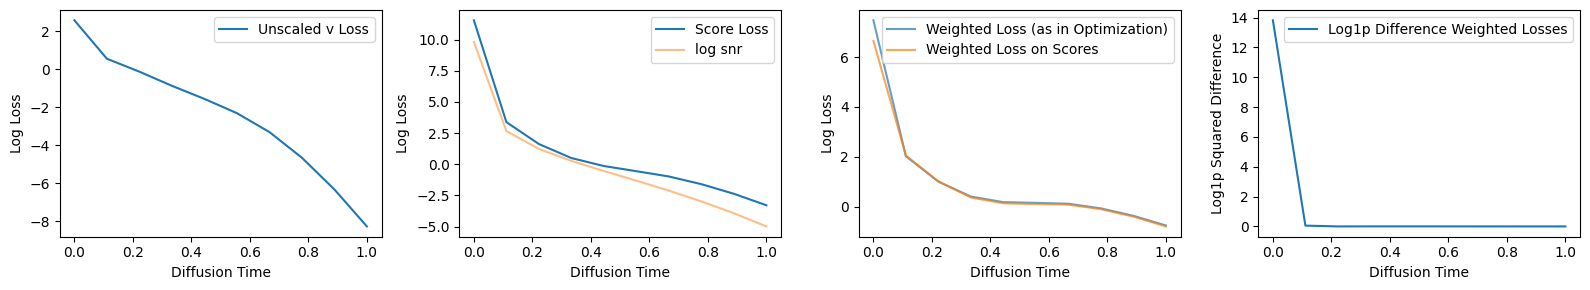

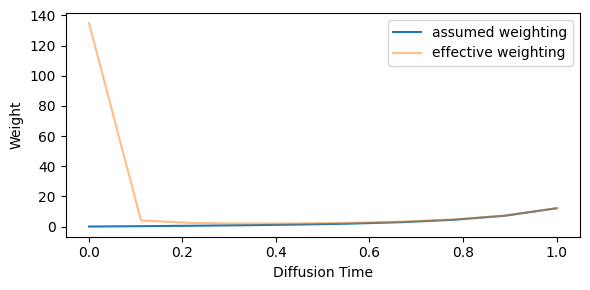

In [16]:
df_error = pd.DataFrame(loss_list_error.items(), columns=['Time', 'Loss'])
df_score = pd.DataFrame(loss_list_score.items(), columns=['Time', 'Loss'])
df_score_w = pd.DataFrame(loss_list_w.items(), columns=['Time', 'Loss'])
df_score_w2 = pd.DataFrame(loss_list_w2.items(), columns=['Time', 'Loss'])

# compute snr
m, std = variance_preserving_kernel(diffusion_time)
snr = (torch.log(torch.square(m)) - torch.log(torch.square(std))).cpu().flatten()


fig, ax = plt.subplots(ncols=4, sharex=True, figsize=(16, 3), tight_layout=True)
ax[0].plot(df_error['Time'], np.log(df_error['Loss']), label=f'Unscaled {score_model.prediction_type} Loss')
ax[1].plot(df_score['Time'], np.log(df_score['Loss']), label='Score Loss')
ax[1].plot(diffusion_time.cpu(), snr, label='log snr', alpha=0.5)
ax[2].plot(df_score_w['Time'], np.log(df_score_w['Loss']), label='Weighted Loss (as in Optimization)', alpha=0.7)
ax[2].plot(df_score_w2['Time'], np.log(df_score_w2['Loss']), label='Weighted Loss on Scores', alpha=0.7)  # should be the same as the loss in optimization
ax[3].plot(df_score_w2['Time'], np.log1p((df_score_w2['Loss']-df_score_w['Loss'])**2), label='Log1p Difference Weighted Losses')
for a in ax:
    a.set_xlabel('Diffusion Time')
    a.set_ylabel('Log Loss')
    a.legend()
ax[-1].set_ylabel('Log1p Squared Difference')
plt.savefig(f'loss_plots_mnist/losses_diffusion_time_{score_model.prediction_type}.png')
plt.show()

plt.figure(figsize=(6, 3), tight_layout=True)
plt.plot(diffusion_time.cpu(), weighting_function(diffusion_time, prediction_type=score_model.prediction_type).cpu().flatten(),
         label='assumed weighting')
plt.plot(diffusion_time.cpu(), weighting_function(diffusion_time, prediction_type=score_model.prediction_type).cpu().flatten() / (variance_preserving_kernel(diffusion_time)[1]**2).cpu().flatten(),
         label='effective weighting', alpha=0.5)
plt.xlabel('Diffusion Time')
plt.ylabel('Weight')
plt.legend()
plt.savefig(f'loss_plots_mnist/weighting_function_{score_model.prediction_type}.png')
plt.show()

# Sample from the Score Model

in comparison the other notebook, I only changed shapes and removed the compositional part (like for the local params)

In [17]:
def euler_maruyama_step(x, score, t, dt):
    """
    Perform one Euler-Maruyama update step for the SDE

    The forward SDE is:
        dX_t = f(X_t, t) dt + g(t) dW_t

    The backward SDE is:
        dX_t = [f(X_t, t) - g(t)^2 * score] * dt + g(t) dW_t

    We assume:
        f(X_t,t) = -0.5 beta(t) * X_t
        g(t) = sqrt(beta(t))

    Parameters:
        x: Current state (PyTorch tensor)
        score: Score network output (PyTorch tensor)
        t: Current time (scalar tensor or float)
        dt: Time step size (PyTorch tensor)

    Returns:
        x_next: Updated state after time dt.
        x_mean: Mean of the Euler-Maruyama update.
    """
    # Compute beta(t)
    beta_t = beta(t)  # scalar value

    # Compute drift f(x, t) = -0.5 * beta(t) * x
    f = -0.5 * beta_t * x

    # Compute diffusion coefficient g(t) = sqrt(beta(t))
    g = torch.sqrt(beta_t)
    g2 = beta_t

    # Compute drift for the backward SDE: f(x, t) - g(t)^2 * score
    drift = f - g2 * score

    # Deterministic update (mean), negative since we are solving the backward SDE
    x_mean = x - drift * dt

    # Stochastic update: add noise scaled by sqrt(dt) and g(t)
    noise = torch.randn_like(x, dtype=x.dtype, device=x.device)
    x_next = x_mean - torch.sqrt(dt) * g * noise
    return x_next, x_mean

In [18]:
# Euler-Maruyama Sampling from Song et al. (2021)
def euler_maruyama_sampling(model, label, diffusion_steps=100, device=None):
    with torch.no_grad():
        model.to(device)
        model.eval()

        label = label.unsqueeze(0).to(device)

        # Initialize parameters
        theta = torch.randn(1, 1, 28, 28, dtype=torch.float32, device=device)

        # Generate diffusion time parameters
        diffusion_time = generate_diffusion_time(size=diffusion_steps, device=device, weighted_time=False) # todo: weighed times

        # Reverse iterate over diffusion times and step sizes
        for t in tqdm(reversed(range(diffusion_steps)), total=diffusion_steps):
            t_tensor = torch.full((1, 1), diffusion_time[t], dtype=torch.float32, device=device)
            scores = model(theta=theta, time=t_tensor, x=label, pred_score=True, clip_x=True)

            # Make Euler-Maruyama step
            if t == 0:
                # do not include noise in the last step
                _, theta = euler_maruyama_step(theta, score=scores, t=diffusion_time[t],
                                              dt=diffusion_time[t])
            else:
                theta, _ = euler_maruyama_step(theta, score=scores, t=diffusion_time[t],
                                               dt=diffusion_time[t] - diffusion_time[t-1])
            if torch.isnan(theta).any():
                print("NaNs in theta")
                break
    return theta.cpu()

In [19]:
# Probability ODE from Song et al. (2021)
from scipy.integrate import solve_ivp
def probability_ode_solving(model, label, device=None):
    with torch.no_grad():
        model.to(device)
        model.eval()

        label = label.unsqueeze(0).to(device)

        # Initialize parameters
        theta = torch.randn(1, 1, 28, 28, dtype=torch.float32, device=device)

        # Reverse iterate over diffusion times and step sizes
        def probability_ode(t, x):
            t_tensor = torch.full((1, 1), t, dtype=torch.float32, device=device)
            x_torch = torch.tensor(x.reshape(1, 1, 28, 28), dtype=torch.float32, device=device)

            scores = model(theta=x_torch, time=t_tensor, x=label, pred_score=True, clip_x=True)

            # Compute beta(t)
            beta_t = beta(t_tensor)  # scalar value

            # Compute drift f(x, t) = -0.5 * beta(t) * x
            f = -0.5 * beta_t * x_torch

            # Compute diffusion coefficient g(t)^2 = beta(t)
            g2 = beta_t

            # Compute drift of ODE
            drift = f - 0.5*g2 * scores
            return drift.cpu().numpy().reshape(28*28)

        x_0 = theta.cpu().numpy().reshape(28*28)
        sol = solve_ivp(probability_ode, t_span=[1, 1e-3], y0=x_0, method='RK45', t_eval=[1e-3])
        print('ODE solved:', sol.success)
        if not sol.success:
            print(sol.message)

    return sol.y[:, -1].reshape(1, 1, 28, 28)

In [20]:
def dynamic_step_size_extrapolation(
    model, label,
    e_abs: float = 0.00078,
    e_rel: float = 1e-3,
    # Initial step size
    h_init: float = 0.01,
    # Factor by which to shrink step if error is too large
    r: float = 0.9,
    adapt_safty: float = 0.9,  # determines how strongly we adapt the step size (0 being very safe; 1 being fast, but high rejections rate)
    # Maximum number of steps to avoid infinite loops
    max_steps: int = 1000,
    # Start and end times
    t_start: float = 1.0,
    t_end: float = 1e-3,
    device = None
):
    with torch.no_grad():
        model.to(device)
        model.eval()

        label = label.unsqueeze(0).to(device)

        # Initialize parameters
        theta = torch.randn(1, 1, 28, 28, dtype=torch.float32, device=device)

        # Current sample and time
        current_t = t_start
        h = h_init
        e_abs = torch.full((1, 1, 28, 28), e_abs, dtype=torch.float32, device=device)

        theta_prev = theta
        for steps in tqdm(range(max_steps)):
            # 1) Draw noise z ~ N(0, I)
            z = torch.randn_like(theta, dtype=torch.float32, device=device)
            t_tensor = torch.full((1, 1), current_t, dtype=torch.float32, device=device)

            ################## Euler-Maruyama Step ##################
            scores = model(theta=theta, time=t_tensor, x=label, pred_score=True, clip_x=True)

            # Compute beta(t)
            beta_t = beta(t_tensor)  # scalar value

            # Compute drift f(x, t) = -0.5 * beta(t) * x
            f = -0.5 * beta_t * theta

            # Compute diffusion coefficient g(t) = sqrt(beta(t))
            g = torch.sqrt(beta_t)
            g2 = beta_t
            # negative signs since we are solving the backward SDE
            theta_eul = theta - h * f + h * g2 * scores + np.sqrt(h) * g * z

            ################## Improved step (Heun-style / 2nd-order SDE) ##################
            t_mid = t_tensor - h
            scores_mid = model(theta=theta_eul, time=t_mid, x=label, pred_score=True, clip_x=True)

            # Compute beta(t)
            beta_t_mid = beta(t_mid)  # scalar value

            # Compute drift f(x, t) = -0.5 * beta(t) * x
            f_mid = -0.5 * beta_t_mid * theta

            # Compute diffusion coefficient g(t) = sqrt(beta(t))
            g_mid = torch.sqrt(beta_t_mid)
            g2_mid = beta_t_mid
            theta_eul_mid = theta - h * f_mid + h * g2_mid * scores_mid + np.sqrt(h) * g_mid * z

            # Compute theta at the midpoint
            theta_eul_sec = 0.5 * (theta_eul + theta_eul_mid)

            ################# Error estimation ##################
            delta = torch.maximum(e_abs, e_rel*torch.maximum(torch.abs(theta_eul), torch.abs(theta_prev)))
            E2 = 1/np.sqrt(28*28) * torch.linalg.matrix_norm((theta_eul - theta_eul_sec) / delta, ord=torch.inf).item()  # infinity norm since SDE is small

            # 5) Accept or reject the step
            if E2 <= 1.0:
                # Accept the step
                theta = theta_eul_sec
                current_t = current_t - h
                theta_prev = theta_eul
            # check if nan
            elif np.isnan(E2).any():
                print("NaNs in E2")
                break
            elif torch.isnan(theta).any():
                print("NaNs in theta")
                theta = theta_prev
                break

            # shrink h
            h = min(current_t-t_end, h * adapt_safty * E2**(-r))

            if current_t <= t_end:
                break

    print(f"Finished after {steps+1} steps at time {current_t}.")
    return theta.cpu()

# Validation

In [21]:
# get validation samples
n_valid = 10
valid_data = next(iter(val_loader))[0][:n_valid]
valid_label = next(iter(val_loader))[1][:n_valid]

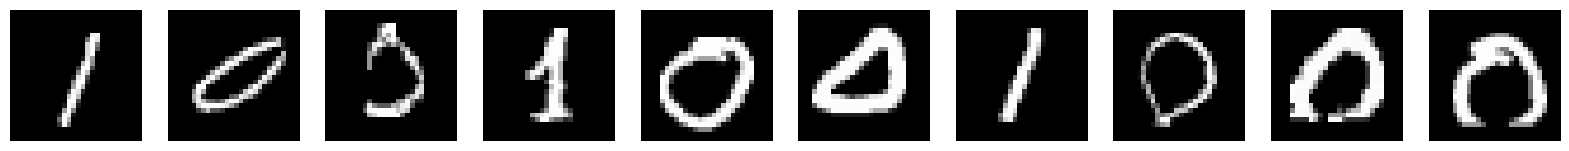

Labels: tensor([1, 0, 0, 1, 0, 0, 1, 0, 0, 0])


In [22]:
fig, ax = plt.subplots(1, n_valid, figsize=(n_valid*2, 2))
for i in range(n_valid):
    ax[i].imshow(valid_data[i].squeeze().cpu().numpy(), cmap='gray')
    ax[i].axis('off')
plt.show()

print('Labels:', valid_label)

In [23]:
sampled_images = np.array([dynamic_step_size_extrapolation(score_model, vd, e_rel=0.01, max_steps=1000,
                                                          device=torch_device)
                                        for vd in valid_label])

 26%|██▌       | 255/1000 [00:04<00:13, 54.81it/s]


Finished after 256 steps at time 0.001.


 26%|██▌       | 258/1000 [00:04<00:12, 57.15it/s]


Finished after 259 steps at time 0.001.


 26%|██▌       | 258/1000 [00:04<00:13, 56.59it/s]


Finished after 259 steps at time 0.001.


 26%|██▌       | 258/1000 [00:04<00:12, 57.92it/s]


Finished after 259 steps at time 0.001.


 25%|██▍       | 249/1000 [00:04<00:13, 54.23it/s]


Finished after 250 steps at time 0.001.


 26%|██▌       | 259/1000 [00:04<00:13, 55.73it/s]


Finished after 260 steps at time 0.001.


 26%|██▌       | 258/1000 [00:04<00:13, 56.37it/s]


Finished after 259 steps at time 0.001.


 26%|██▌       | 259/1000 [00:04<00:13, 54.42it/s]


Finished after 260 steps at time 0.001.


 24%|██▍       | 244/1000 [00:04<00:13, 55.85it/s]


Finished after 245 steps at time 0.001.


 25%|██▍       | 247/1000 [00:04<00:13, 55.65it/s]

Finished after 248 steps at time 0.001.


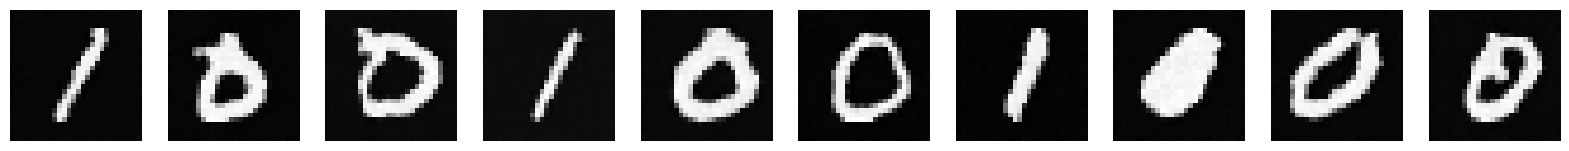

In [24]:
# plot sampled images
fig, ax = plt.subplots(1, n_valid, figsize=(n_valid*2, 2))
for i in range(n_valid):
    ax[i].imshow(sampled_images[i].squeeze(), cmap='gray')
    ax[i].axis('off')
plt.show()

In [25]:
sampled_images_euler = np.array([euler_maruyama_sampling(score_model, vd, diffusion_steps=300,
                                                          device=torch_device)
                                        for vd in valid_label])

100%|██████████| 300/300 [00:02<00:00, 124.50it/s]


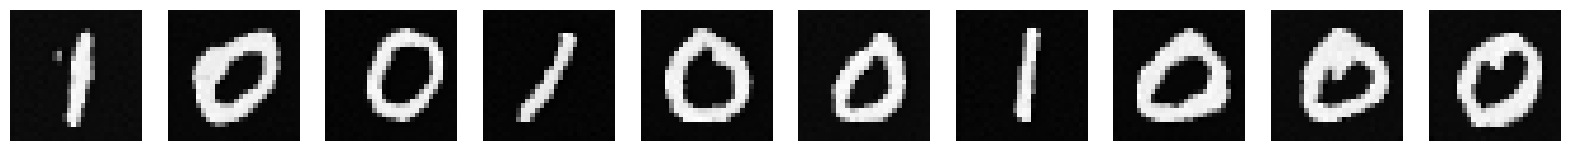

In [26]:
# plot sampled images
fig, ax = plt.subplots(1, n_valid, figsize=(n_valid*2, 2))
for i in range(n_valid):
    ax[i].imshow(sampled_images_euler[i].squeeze(), cmap='gray')
    ax[i].axis('off')
plt.show()

In [27]:
ode_images = np.array([probability_ode_solving(score_model, vd, device=torch_device)
                                        for vd in valid_label])

ODE solved: True
ODE solved: True
ODE solved: True
ODE solved: True
ODE solved: True
ODE solved: True
ODE solved: True
ODE solved: True
ODE solved: True
ODE solved: True


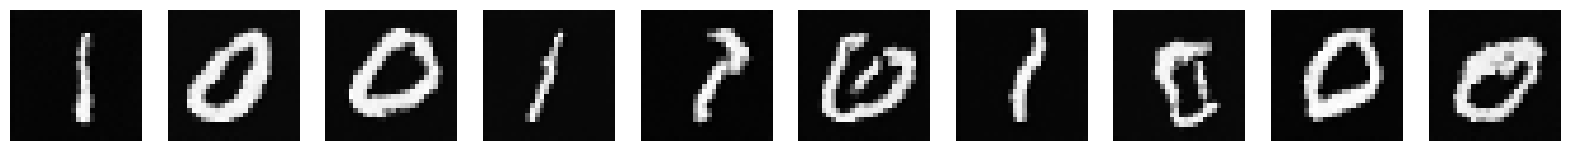

In [28]:
# plot sampled images
fig, ax = plt.subplots(1, n_valid, figsize=(n_valid*2, 2))
for i in range(n_valid):
    ax[i].imshow(ode_images[i].squeeze(), cmap='gray')
    ax[i].axis('off')
plt.show()